## Import Libraries

In [7]:
import sys

sys.path.append('/home/michele.prencipe/tesi/transformer/swin2sr')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
from data_loader.read_mrc import read_mrc
from tests.training import *
from skimage import io, color
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
set_global_seed(42)

## Set Directories

In [8]:
from data_loader.biosr_dataset import BioSRDataLoader

# Define your working directory and data directory
work_dir = "."
tensorboard_log_dir = os.path.join(work_dir, "tensorboard_logs")
os.makedirs(tensorboard_log_dir, exist_ok=True)
data_dir = '/group/jug/ashesh/data/BioSR/'


## Load Data

In [9]:
from configs.biosr_config import get_config
config = get_config()

resize_to_shape = (768,768) #to put it into the config

#dataset, train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader = create_dataset(config, 
                                                  #  datadir='/group/jug/ashesh/data/BioSR/', noisy_data = False)


In [10]:
#from configs.biosr_config import get_config
config = get_config()

resize_to_shape = (768,768) #to put it into the config

noisy_dataset, noisy_train_dataset, noisy_val_dataset, noisy_test_dataset, noisy_train_loader, noisy_val_loader, noisy_test_loader = create_dataset(config,
                                                                                                                datadir='/group/jug/ashesh/data/BioSR/',
                                                                                                                noisy_data = True, noisy_factor = 1000, gaus_factor = 1000)


Resizing to shape (768, 768). MUST BE REMOVED IN PRODUCTION!
Norm Param:  0 0 65494 64074
c1_data shape: (768, 768, 68)
c2_data shape: (768, 768, 54)


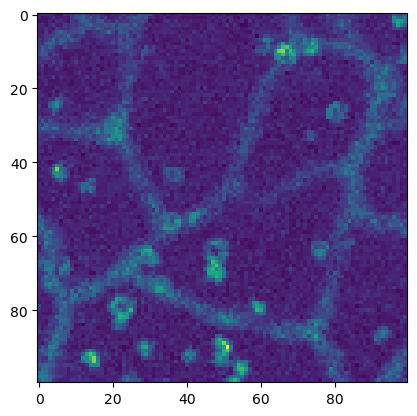

In [13]:
plt.imshow(noisy_dataset[0][0][300:400,300:400])

## Create Model

### Swin2SR

In [14]:
# depths = [6, 6, 6, 6]
# num_heads = [6, 6, 6, 6]
depths = [3, 3]
num_heads = [3, 3]

from tests.training import Swin2SRModule
from configs.biosr_config import get_config

config = get_config()

# Initialize the model
model = Swin2SRModule(config)


model.load_state_dict(torch.load('/home/michele.prencipe/tesi/transformer/swin2sr/logdir/4aul5ofoswin2sr'))

<All keys matched successfully>

## Inference

In [17]:
from torch import nn as nn
# Validation loop (optional but recommended)
model.eval()  # Set model to evaluation mode
model = model.cuda()
criterion = nn.MSELoss()
val_loss = 0.0
test_inputs = []
test_outputs = []
test_targets = []
c1_min, c1_max, c2_min, c2_max = noisy_dataset.get_normalization_params() #of the entire dataset
print(c1_max, c2_max, c1_min, c2_min)

with torch.no_grad():
    for inputs, targets in noisy_test_loader:
        inputs, targets = inputs.cuda(), targets.cuda()                

        # Ensure inputs and targets have the correct dimensions
        if len(inputs.shape) == 3:  # If inputs are [batch_size, height, width]
            inputs = inputs.unsqueeze(1)  # Add channel dimension to make it [batch_size, 1, height, width]
        if len(targets.shape) == 3:  # If targets are [batch_size, height, width]
            targets = targets.unsqueeze(1)  # Add channel dimension to make it [batch_size, 1, height, width]

        outputs = model(inputs)  # Forward pass   
        
        loss = criterion(outputs, targets)  # Compute loss
        
        val_loss += loss.item()  # Accumulate loss
        
        targets[:,0,:,:] = targets[:,0,:,:]*(c1_max - c1_min) + c1_min
        targets[:,1,:,:] = targets[:,1,:,:]*(c2_max - c2_min) + c2_min
        outputs[:,0,:,:]  = outputs[:,0,:,:]*(c1_max - c1_min) + c1_min
        outputs[:,1,:,:]  = outputs[:,1,:,:]*(c2_max - c2_min) + c2_min
                
        test_inputs.append(inputs.cpu().numpy())
        test_outputs.append(outputs.cpu().numpy())
        test_targets.append(targets.cpu().numpy())

        # Ensure outputs and targets have the same dimensions for loss computation
        if outputs.shape != targets.shape:
            print(f"Output shape: {outputs.shape}, Target shape: {targets.shape}")
            raise ValueError("Output and target shapes do not match!")       

test_inputs = np.concatenate(test_inputs, axis=0)
test_outputs = np.concatenate(test_outputs, axis=0)
test_targets = np.concatenate(test_targets, axis=0)

# Compute average validation loss for the epoch
val_loss = val_loss / len(noisy_test_loader)
print(f'Validation Loss: {val_loss:.9f}')


65494 64074 0 0


NameError: name 'test_loader' is not defined

## Metric Calculation

In [36]:
from collections import defaultdict
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from utils.util_calculate_psnr_ssim import calculate_psnr, calculate_ssim
from core.psnr import PSNR

psnr_arr = {0: [], 1: []}
ssim_arr = defaultdict(list)


for ch_idx in range(test_outputs.shape[1]):
    if ch_idx == 0:
        data_range = c1_max - c1_min
    else: 
        data_range = c2_max - c2_min
    psnr_arr[ch_idx].append(PSNR(test_targets[:, ch_idx, :, :], test_outputs[:, ch_idx, : , : ], range_= data_range))
    

In [30]:
print(psnr_arr)

{0: [tensor([40.5013, 38.4568, 41.8355, 37.6287, 38.1656, 41.9352])], 1: [tensor([40.6247, 40.4100, 41.5370, 43.5374, 40.2614, 43.5199])]}


In [37]:
print("psnr channel 1:", np.mean(psnr_arr[0]))
print("psnr channel 2:", np.mean(psnr_arr[1]))

psnr channel 1: 39.75384
psnr channel 2: 41.648403


## Visual Evaluation

Index: 4


Text(0.5, 1.0, 'Target')

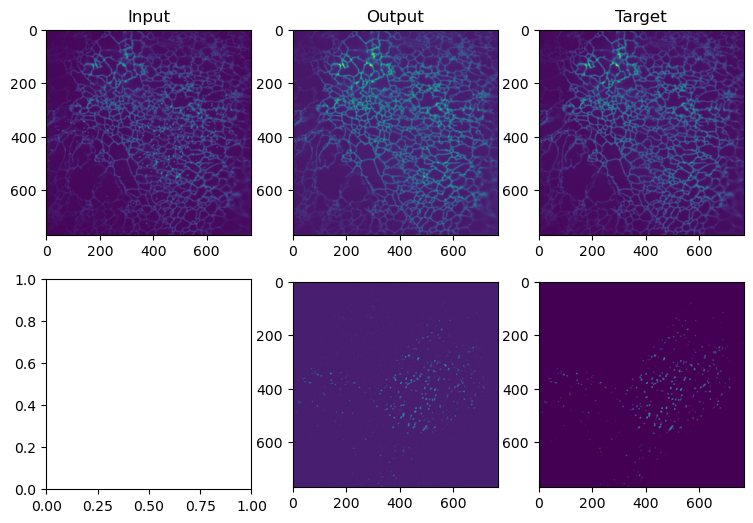

In [38]:
idx = np.random.randint(0,len(test_inputs))
print(f"Index: {idx}")
img_sz = 3
ncols = 3
nrows = 2
_, ax = plt.subplots(figsize=(img_sz*ncols, img_sz*nrows), ncols=ncols,nrows=nrows)
ax[0,0].imshow(test_inputs[idx,0])
ax[0,1].imshow(test_outputs[idx,0])
ax[0,2].imshow(test_targets[idx,0])
ax[1,1].imshow(test_outputs[idx,1])
ax[1,2].imshow(test_targets[idx,1])

ax[0,0].set_title('Input')
ax[0,1].set_title('Output')
ax[0,2].set_title('Target')

In [33]:
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.cuda(), targets.cuda()
                

        # Ensure inputs and targets have the correct dimensions
        if len(inputs.shape) == 3:  # If inputs are [batch_size, height, width]
            inputs = inputs.unsqueeze(1)  # Add channel dimension to make it [batch_size, 1, height, width]
        if len(targets.shape) == 3:  # If targets are [batch_size, height, width]
            targets = targets.unsqueeze(1)  # Add channel dimension to make it [batch_size, 1, height, width]
       
        outputs = model(inputs) # Forward pass        
        
        outputs = outputs.cpu().numpy()
        targets = targets.cpu().numpy()
        
        targets[:,0,:,:] = targets[:,0,:,:]*(c1_max - c1_min) + c1_min
        targets[:,1,:,:] = targets[:,1,:,:]*(c2_max - c2_min) + c2_min
        outputs[:,0, :,:]  = outputs[:,0,:,:]*(c1_max - c1_min) + c1_min
        outputs[:,1, :,:]  = outputs[:,1,:,:]*(c2_max - c2_min) + c2_min
        
        break


In [34]:
print(PSNR(targets[:,0, ...], outputs[:,0, ...], range_ = c1_max - c1_min))

tensor([38.4226, 38.4568])


In [35]:
print(np.min(outputs[0,0]))
print(np.max(outputs[0,0]))
print(np.min(targets[0,0]))
print(np.max(targets[0,0]))

-1535.3324
57675.793
376.0
64297.0
